In [26]:
import os
import json
from typing import Dict, List, Optional, Union, cast
from env import github_token, github_username
import acquire
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import regex as re
import time
import numpy as np
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import prepare_repos
import collections
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
def create_urls(num=5000):
    ''' this function scrapes the cryptography repositories from github and returns a list of urls
    '''
    num_of_repos=num

    page_numbers = [i for i in range(0,101)]
    print(page_numbers)
    urls = [f'https://github.com/search?p={i}&q=%23defi&type=Repositories&per_page=100' for i in page_numbers]

    print(urls)
    return urls

##### create_urls()

In [ ]:
def get_endpoints(url):
    ''' This function gets the endpoints from the list of above urls
    '''

    headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}
    
    while True:
        response = requests.get(url, headers=headers)
        if response.ok:
            break
        else:
            print('sleeping')
            time.sleep(20)
            continue
    soup = BeautifulSoup(response.text)
    
    print(response.ok)

    endpoints = []
    subgroups = soup.find_all('div', {"class":"f4 text-normal"})

    for group in subgroups:
        endpoints.append(re.search('href=".*"', str(group))[0][6:-1])

    return endpoints

In [ ]:
get_endpoints('https://github.com/search?p=100&q=%23defi&type=Repositories&per_page=100')

In [ ]:
def make_all_endpoints():
    ''' This function returns all of the endpoints
    '''
    urls = create_urls()
    for url in urls:
        print(url)
    all_endpoints = []

    for i, page in enumerate(urls):
        all_endpoints.append(get_endpoints(page))
        print(page)

    print(len(all_endpoints))

    return all_endpoints

In [ ]:
make_all_endpoints()

In [ ]:
def acquire_endpoints():
    ''' This function acquires all endpoints and writes them to a csv.
    '''
    our_endpoints = pd.Series(make_all_endpoints(), name='endpoints')
    our_endpoints.to_csv('endpoints.csv', index=False)

    return our_endpoints

In [ ]:
x=acquire_endpoints()

In [ ]:
def flatten_endpoints():
    ''' This function flattens a 2d array into a 1d array
    '''
    end_points = pd.read_csv('endpoints.csv')
    all_values = []
    for value in end_points.values:
        for ep in value:
            all_values.append(ep)

    final_values = []
    #print(all_values)
    for value in all_values:
        for val in value.split("'"):
            if len(val) > 3:
                final_values.append(val)
                print(val)

    return pd.Series(final_values, name='endpoints')

In [ ]:
endpoints = flatten_endpoints()

In [ ]:
REPOS = list(endpoints)

In [ ]:
REPOS[5:]

In [ ]:

headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )


def github_api_request(url: str) -> Union[List, Dict]:
    ''' This function makes requests from github and raises an error code if a specific error code is received.
    '''
    response = requests.get(url, headers=headers)
    response_data = response.json()
    if response.status_code != 200:
        raise Exception(
            f"Error response from github api! status code: {response.status_code}, "
            f"response: {json.dumps(response_data)}"
        )
    return response_data


def get_repo_language(repo: str) -> str:
    ''' This function fetches the language associated with a repository
    '''
    url = f"https://api.github.com/repos{repo}"
    repo_info = github_api_request(url)
    if type(repo_info) is dict:
        repo_info = cast(Dict, repo_info)
        if "language" not in repo_info:
            raise Exception(
                "'language' key not round in response\n{}".format(json.dumps(repo_info))
            )
        return repo_info["language"]
    raise Exception(
        f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
    )

def get_repo_contents(repo: str) -> List[Dict[str, str]]:
    ''' This function fetches the contents associated with a repo
    '''
    url = f"https://api.github.com/repos{REPOS}/contents/"
    contents = github_api_request(url)
    if type(contents) is list:
        contents = cast(List, contents)
        return contents
    raise Exception(
        f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
    )

def get_readme_download_url(files: List[Dict[str, str]]) -> str:
    """
    Takes in a response from the github api that lists the files in a repo and
    returns the url that can be used to download the repo's README file.
    """
    for file in files:
        if file["name"].lower().startswith("readme"):
            return file["download_url"]
    return ""

def process_repo(repo: str) -> Dict[str, str]:
    """
    Takes a repo name like "gocodeup/codeup-setup-script" and returns a
    dictionary with the language of the repo and the readme contents.
    """
    contents = get_repo_contents(repo)
    readme_download_url = get_readme_download_url(contents)
    if readme_download_url == "":
        readme_contents = ""
    else:
        response = requests.get(readme_download_url)
        print(readme_download_url)
        print(response.status_code)
        readme_contents = requests.get(readme_download_url).text
        
    return {
        "repo": repo,
        "language": get_repo_language(repo),
        "readme_contents": readme_contents,
    }


In [ ]:
def scrape_github_data() -> List[Dict[str, str]]:
    """
    Loop through all of the repos and process them. Returns the processed data.
    """
    
    output = []
    for repo in REPOS:
        
        url = f"https://api.github.com/repos{repo}/contents/"
        print(repo)
        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"Skipping {repo} because its HTTP status code is {response.status_code}")
            continue
        
        contents = response.json()
        readme_download_url = get_readme_download_url(contents)
        
        if readme_download_url == "":
            readme_contents = ""
        else:
            response = requests.get(readme_download_url)
            if response.status_code != 200:
                print(f"Skipping {repo} because its HTTP status code is {response.status_code}")
                continue
            readme_contents = requests.get(readme_download_url).text
        print(repo)
        result = {
            "repo": repo,
            "language": get_repo_language(repo),
            "readme_contents": readme_contents,
        }
    
        output.append(result)
        
    return output

In [ ]:
data = scrape_github_data()

In [ ]:
data[:5]

In [ ]:
import csv
to_csv = data
keys = to_csv[0].keys()
#save to csv
with open('data.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(to_csv)

In [2]:
# open csv
df = pd.read_csv('data.csv') 
df.head()

,repo,language,readme_contents
0,/OffcierCia/DeFi-Developer-Road-Map,NaN,# DeFi Developer Road Map\n\n**Here we collect...
1,/smartcontractkit/full-blockchain-solidity-cou...,NaN,<!-- [YouTube Video](https://www.youtube.com/w...
2,/rainbow-me/rainbow,TypeScript,![](https://pbs.twimg.com/profile_banners/1103...
3,/Bytom/bytom,Go,Bytom\n======\n\n[![Build Status](https://trav...
4,/DimensionDev/Maskbook,TypeScript,<!-- cspell:disable -->\n<!-- markdownlint-dis...


In [ ]:
df.language.value_counts()

### Prepare

In [ ]:
df.isnull().sum()

In [4]:
df = df.dropna()
df.shape

(976, 3)

In [3]:
df = prepare_repos.fill_nulls(df)
df.shape

(1010, 3)

In [5]:
df['readme_contents'] = df.readme_contents.apply(prepare_repos.basic_clean)
df.head()

,repo,language,readme_contents
0,/OffcierCia/DeFi-Developer-Road-Map,Not Specified,defi developer road map\n\n here we collect...
1,/smartcontractkit/full-blockchain-solidity-cou...,Not Specified,youtube video https www youtube com w...
2,/rainbow-me/rainbow,TypeScript,https pbs twimg com profile banners 1103...
3,/Bytom/bytom,Go,bytom\n \n\n build status https trav...
4,/DimensionDev/Maskbook,TypeScript,cspell disable \n markdownlint dis...


In [6]:
df['readme_contents'] = df.readme_contents.apply(prepare_repos.tokenize).apply(prepare_repos.lemmatize).apply(prepare_repos.remove_stopwords)
df.head()

,repo,language,readme_contents
0,/OffcierCia/DeFi-Developer-Road-Map,Not Specified,defi developer road map collect discus best de...
1,/smartcontractkit/full-blockchain-solidity-cou...,Not Specified,youtube video http www youtube com watch v m57...
2,/rainbow-me/rainbow,TypeScript,http pb twimg com profile banner 1103191459409...
3,/Bytom/bytom,Go,bytom build status http travis ci org bytom by...
4,/DimensionDev/Maskbook,TypeScript,cspell disable markdownlint disable inline htm...


In [ ]:
df['word_count'] = df['readme_contents'].apply(lambda x : len(x.split()))

In [ ]:
df['num_unique_words'] = df['readme_contents'].apply(lambda x: len(set(w for w in x.split())))
df['num_repeated_words'] = df['readme_contents'].apply(lambda x: len([w for w in collections.Counter(x.split()).values() if w > 1]))
df['character_count'] = df['readme_contents'].apply(lambda x : len(x.replace(" ","")))
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.word_count.plot()

In [ ]:
df.to_csv('clean_df.csv', index = False)

In [ ]:
fig = px.bar(df, x='language', y='word_count', title='Counts of words', template='plotly_white', labels={'ngram': 'Bigram', 'count': 'Count'})
fig.show()

In [ ]:
fig = px.histogram(df, x='language', template='plotly_white', title='Complain counts by length')
fig.update_xaxes(categoryorder='total descending', title='Number of words (clipped at 1000 words)').update_yaxes(title='Number of complaints')
fig.show()

In [ ]:
df.head()

In [12]:
# Limit languagues with less than 4 spots in a repo
remaining_languages = df.language.value_counts()[df.language.value_counts() > 4].index

# Removing languages not kept
df = df[df.language.isin(remaining_languages)]

In [ ]:
df.shape

In [ ]:
labels = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

In [ ]:
df.language.value_counts()

In [ ]:
java_words = prepare_repos.clean(' '.join(df[df.language == 'JavaScript'].readme_contents))
Tscript_words = prepare_repos.clean(' '.join(df[df.language == 'TypeScript'].readme_contents))
all_words = prepare_repos.clean(' '.join(df.readme_contents))
idk_words = prepare_repos.clean(' '.join(df[df.language == 'Not Specified'].readme_contents))
solidity_words = prepare_repos.clean(' '.join(df[df.language == 'Solidity'].readme_contents))
python_words = prepare_repos.clean(' '.join(df[df.language == 'Python'].readme_contents))

In [ ]:
java_words

In [ ]:
java_freq = pd.Series(java_words).value_counts()
Tscript_freq = pd.Series(Tscript_words).value_counts()
all_freq = pd.Series(all_words).value_counts()
idk_freq = pd.Series(idk_words).value_counts()
solidity_freq = pd.Series(solidity_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
java_freq.head()

In [ ]:
Tscript_freq.head()

In [ ]:
word_counts = (pd.concat([all_freq, java_freq, Tscript_freq, idk_freq, solidity_freq, python_freq], axis=1, sort=True)
                .set_axis(['all', 'java', 'TypeScript', 'Not_Specified', 'Solidity', 'Python'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(15)

In [ ]:
word_counts.sort_values(by='TypeScript', ascending=False).head(10)

In [ ]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
java_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(java_words))
Tscript_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(Tscript_words))
idk_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(idk_words))
Solidity_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(solidity_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(python_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, .5, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(java_cloud)
axs[2].imshow(Tscript_cloud)
axs[3].imshow(idk_cloud)
axs[4].imshow(Solidity_cloud)
axs[5].imshow(python_cloud)

axs[0].set_title('All Words')
axs[1].set_title('java')
axs[2].set_title('Tscript_words')
axs[3].set_title('Not Specified')
axs[4].set_title('solidity')
axs[5].set_title('python')

for ax in axs: ax.axis('off')

In [ ]:
Solidity_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(solidity_words))
plt.imshow(Solidity_cloud)


In [ ]:
word_counts.head()

In [ ]:
(word_counts
 .assign(p_java=word_counts.java / word_counts['all'],
         p_TypeScript=word_counts.TypeScript / word_counts['all'],
         p_idk=word_counts.Not_Specified / word_counts['all'],
         p_Solidity=word_counts.Solidity / word_counts['all'],
         p_python=word_counts.Python / word_counts['all'])
 .sort_values(by='all')
 [['java', 'TypeScript', 'Solidity', 'Not_Specified', 'Python']]
 .tail(20)
 .sort_values('java')
 .plot.barh(stacked=True))

plt.title('Proportion of language for the 20 most common words')

In [ ]:
df.head()

In [ ]:
df.head()

In [13]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, stratify=y, test_size=.2)
X_validate, X_test, y_validate, y_test = train_test_split(X_test_val, y_test_val, stratify=y_test_val, test_size=.5)


In [19]:
y_train

,language
582,Not Specified
225,TypeScript
33,Not Specified
226,JavaScript
584,TypeScript
...,...
366,JavaScript
742,HTML
24,Python
70,TypeScript


In [15]:
# turn X_ into df with features 
X_train_df= pd.DataFrame(X_train.todense(), columns=tfidf.get_feature_names())
X_validate_df= pd.DataFrame(X_validate.todense(), columns=tfidf.get_feature_names())
X_test_df= pd.DataFrame(X_test.todense(), columns=tfidf.get_feature_names())

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
# turn y_ into df
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

## baseline 

In [ ]:
df.language.value_counts()

In [20]:
# new df for predictions
predictions = pd.DataFrame({ 
    'actual': y_train.language
})


In [22]:
predictions['baseline'] = y_train[y_train['language'] == 'JavaScript'].shape[0] /y_train.shape[0]

In [23]:
predictions.head()

,actual,baseline
582,Not Specified,0.243351
225,TypeScript,0.243351
33,Not Specified,0.243351
226,JavaScript,0.243351
584,TypeScript,0.243351


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(df['readme_contents'])
tfidfs

In [ ]:
features= pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
features

In [ ]:
features.info()

In [ ]:
df['readme_contents'].head()

In [ ]:
 #From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
df2 = (pd.DataFrame({'raw_count': word_counts.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

In [ ]:
X_train.head()

In [ ]:
X_train.info()

[Text(0.5, 0.875, 'yarn <= 0.016\ngini = 0.832\nsamples = 752\nvalue = [8, 10, 9, 20, 18, 183, 8, 100, 45, 26, 10, 130\n176, 9]\nclass = JavaScript'),
 Text(0.25, 0.625, 'pip <= 0.004\ngini = 0.844\nsamples = 592\nvalue = [8, 10, 8, 19, 13, 148, 8, 100, 44, 22, 10, 107\n89, 6]\nclass = JavaScript'),
 Text(0.125, 0.375, 'npm <= 0.006\ngini = 0.837\nsamples = 566\nvalue = [8, 10, 8, 19, 13, 148, 8, 99, 22, 22, 10, 104\n89, 6]\nclass = JavaScript'),
 Text(0.0625, 0.125, 'gini = 0.85\nsamples = 396\nvalue = [8, 9, 7, 19, 10, 74, 7, 96, 21, 19, 8, 73, 43\n2]\nclass = Not Specified'),
 Text(0.1875, 0.125, 'gini = 0.702\nsamples = 170\nvalue = [0, 1, 1, 0, 3, 74, 1, 3, 1, 3, 2, 31, 46, 4]\nclass = JavaScript'),
 Text(0.375, 0.375, 'npm <= 0.012\ngini = 0.269\nsamples = 26\nvalue = [0, 0, 0, 0, 0, 0, 0, 1, 22, 0, 0, 3, 0, 0]\nclass = Python'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 22\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0]\nclass = Python'),
 Text(0.4375, 0.125, 'gini = 0.37

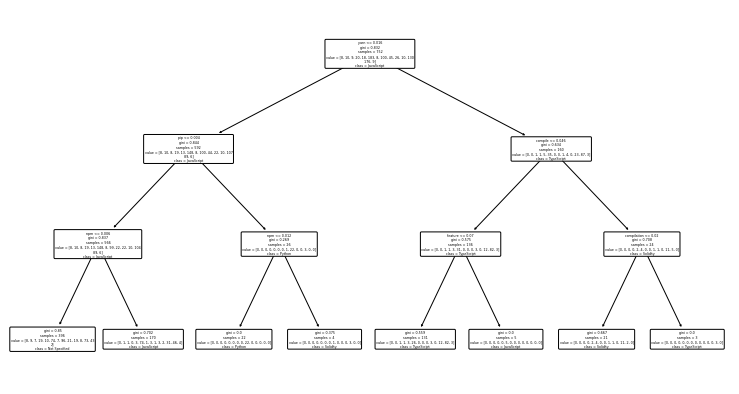

In [24]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
clf = clf.fit(X_train_df, y_train)

plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train_df.columns, class_names=clf.classes_, rounded=True)

In [28]:
X_train_df

,00,000,0000,000000,00000000,000000000000000000,0000000000000000000000000000000000000000000000000000000000000001,000000000000000002,000000000000000282,00000000000009764515173366604499968328796917891,...,zzutbyhibihwi3qvkmone1dgl03vtm1w8oddusjedkbpbvaa8,zzuy29j4eoph7crhhnsaoqjid15ui3xwkxcxk5v5zxlqpez8rnuspt08meyoyovvfxpgql,zzvgq2npaunvb63owt33x,zzw,zzwmavvvbp3yapsrmfp4nswdwuaqiecbagqiaagrdivtjzx0zt85z9zf8a8rtn,zzxthngejsu8vr,zzxyl,zzy,zzy55b7axooubbgcvqn297r4p,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(y_test, y_pred)

In [31]:
predictions['DT'] = clf.predict(X_train_df)



print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train_df, y_train)))
predictions['DT'] = clf.score(X_train_df, y_train)

Accuracy of Decision Tree classifier on training set: 0.39


In [32]:
predictions.head()

,actual,baseline,DT
582,Not Specified,0.243351,0.393617
225,TypeScript,0.243351,0.393617
33,Not Specified,0.243351,0.393617
226,JavaScript,0.243351,0.393617
584,TypeScript,0.243351,0.393617
